In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.qc import *
from src.energy_calculation import *
from src.utils import write_to_csv 
sns.set_theme(font_scale=1.5)
from tqdm import tqdm
import tikzplotlib
from scipy.optimize import minimize
import pandas as pd

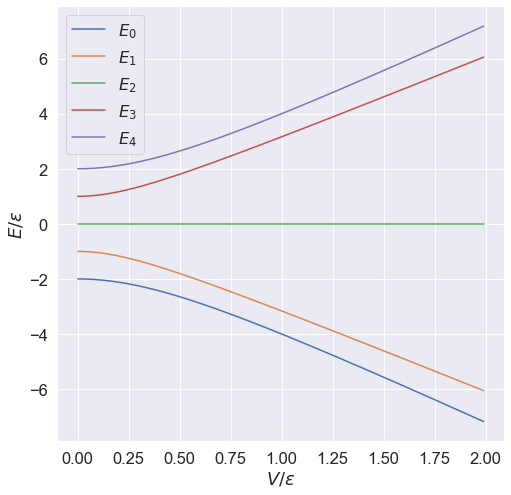

In [2]:
def Hamiltonian(v):    
    H = np.array([[-2, 0, -np.sqrt(6)*v, 0, 0], 
                  [0, -1, 0, -3*v, 0],
                  [-np.sqrt(6)*v, 0, 0, 0, -np.sqrt(6)*v], 
                  [0, -3*v, 0, 1, 0], 
                  [0, 0, -np.sqrt(6)*v, 0, 2]])
    return H

v_vals_ana = np.arange(0, 2, 0.01)
eigvals_ana = np.zeros((len(v_vals_ana), 5))
entropy = np.zeros((len(v_vals_ana), 5))
for index, v in enumerate(v_vals_ana):
    H = Hamiltonian(v)
    eigen, eigvecs = np.linalg.eig(H)
    permute = eigen.argsort()
    eigvals_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]

fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(len(eigvals_ana[0])):
    axs.plot(v_vals_ana, eigvals_ana[:, i], label=f'$E_{i}$')
axs.set_xlabel(r'$V/\epsilon$')
axs.set_ylabel(r'$E/\epsilon$')
axs.legend(loc = 'upper left')
plt.show()

In [3]:
#finding the unitaries that rotate Pauli strings into the measurement basis

qb = Qubit(4)
I, X, Y, CNOT10, CNOT01, SWAP, H, S = qb.I, qb.X, qb.Y, qb.CNOT10, qb.CNOT01, qb.SWAP, qb.H, qb.S
Sdag = S.conj().T
unitaries_individual = []
U_ZIII = np.kron(I, np.kron(I, np.kron(I, I)))
unitaries_individual.append(U_ZIII)
U_IZII = np.kron(np.kron(I, I)@SWAP, np.kron(I, I))
unitaries_individual.append(U_IZII)
U_IIZI = U_IZII@np.kron(I, np.kron(np.kron(I, I)@SWAP, I))
unitaries_individual.append(U_IIZI)
U_IIIZ = U_IIZI@np.kron(I, np.kron(I, np.kron(I, I)@SWAP))
unitaries_individual.append(U_IIIZ)

U_ZIZI = np.kron(CNOT10, np.kron(I, I))@np.kron(I, np.kron(SWAP@np.kron(I, I), I))

U_XX = CNOT10@np.kron(H, H)
U_XI = np.kron(H, I)
U_IX = U_XI@SWAP
U_XXII = np.kron(U_XX, np.kron(I, I))
unitaries_individual.append(U_XXII)
U_XIXI = U_ZIZI@np.kron(U_XI, U_XI)
unitaries_individual.append(U_XIXI)
U_XIIX = U_ZIZI@np.kron(U_XI, U_IX)
unitaries_individual.append(U_XIIX)
U_IXXI = U_ZIZI@np.kron(U_IX, U_XI)
unitaries_individual.append(U_IXXI)
U_IXIX = U_ZIZI@np.kron(U_IX, U_IX)
unitaries_individual.append(U_IXIX)
U_IIXX = U_IIZI@np.kron(I, np.kron(I, U_XX))
unitaries_individual.append(U_IIXX)

U_YY = CNOT10@np.kron(H@Sdag, H@Sdag)
U_YI = np.kron(H@Sdag, I)
U_IY = U_YI@SWAP
U_YYII = np.kron(U_YY, np.kron(I, I))
unitaries_individual.append(U_YYII)
U_YIYI = U_ZIZI@np.kron(U_YI, U_YI)
unitaries_individual.append(U_YIYI)
U_YIIY = U_ZIZI@np.kron(U_YI, U_IY)
unitaries_individual.append(U_YIIY)
U_IYYI = U_ZIZI@np.kron(U_IY, U_YI)
unitaries_individual.append(U_IYYI)
U_IYIY = U_ZIZI@np.kron(U_IY, U_IY)
unitaries_individual.append(U_IYIY)
U_IIYY = U_IIZI@np.kron(np.kron(I, I), U_YY)
unitaries_individual.append(U_IIYY)

In [4]:
number_shots = 10_000
v_vals = np.linspace(0.0, 2.0, 11)
min_energy_individual = np.zeros(len(v_vals))
for index, v in enumerate(tqdm(v_vals)):
    const_z = 0.5*np.ones(4)
    const_x = -v/2*np.ones(6)
    const_y = +v/2*np.ones(6)
    constants_individual = np.concatenate((const_z, const_x, const_y))
    const_term = None 
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 8)
    args = (number_shots, unitaries_individual, prepare_state_individual, constants_individual, const_term)
    res = minimize(get_energy, angles_start, args = args, method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_individual[index] = res.fun

write_to_csv(v_vals, min_energy_individual, header = 'v,energy', filename = 'data/Lipkin_J=2_individual')

100%|██████████| 11/11 [01:56<00:00, 10.62s/it]


In [14]:
qb = Qubit(2)
X, Y, Z, I, H = qb.X, qb.Y, qb.Z, qb.I, qb.H
SWAP, CNOT10 = qb.SWAP, qb.CNOT10
ZI = np.kron(Z, I)
IZ = np.kron(I, Z)
XI = np.kron(X, I)
IX = np.kron(I, X)

U_ZI = np.kron(I, I)
U_IZ = SWAP
U_XI = np.kron(H, I)
U_IX = np.kron(H, I)@SWAP
U_IZXI = U_XI@U_IZ
U_IXZI = U_ZI@U_IX
U_ZX = CNOT10@np.kron(I, H)
U_XZ = U_ZX@SWAP

unitaries_coupled = np.array([U_ZI, U_IZ, U_XI, U_IX, U_XZ, U_ZX])

number_shots = 20_000
v_vals = np.linspace(0.0, 2.0, 11)
min_energy_coupled = np.zeros(len(v_vals))
for index, v in enumerate(tqdm(v_vals)):
    constants1 = -np.ones(2)
    constants2 = -np.sqrt(6)/2*np.array([1, 1, 1, -1])
    const_term = None
    constants_coupled = np.concatenate((constants1, v*constants2))
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 2)
    args = (number_shots, unitaries_coupled, prepare_state_coupled, constants_coupled, const_term)
    res = minimize(get_energy, angles_start, args = args, method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_coupled[index] = res.fun

write_to_csv(v_vals, min_energy_coupled, header = 'v,energy', filename = '../data/Lipkin_J=2_coupled')

100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


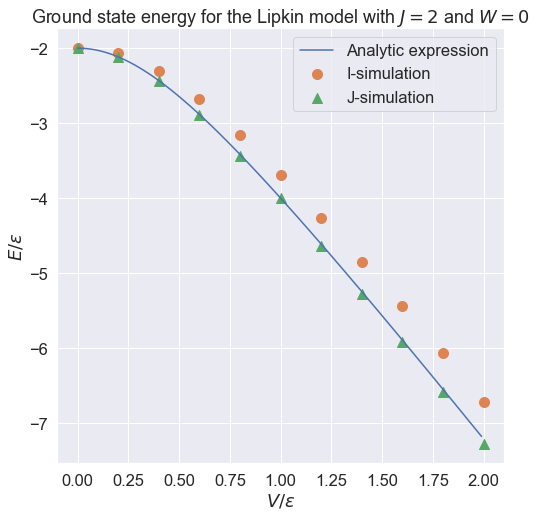

In [5]:
df_ind = pd.read_csv('../data/Lipkin_J=2_individual.csv')
df_cou = pd.read_csv('../data/Lipkin_J=2_coupled.csv')

v_vals = df_ind['v'].to_numpy()
min_energy_individual = df_ind['energy'].to_numpy()
min_energy_coupled = df_cou['energy'].to_numpy()

fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(1):
    axs.plot(v_vals_ana, eigvals_ana[:, i], label=f'Analytic expression')
axs.set_xlabel(r'$V/\epsilon$')
axs.scatter(v_vals, min_energy_individual, label = 'I-simulation', color = '#dd8452', marker = 'o', s = 100)
axs.scatter(v_vals, min_energy_coupled, label = 'J-simulation', color = '#55a868', marker = '^', s = 100)
axs.set_ylabel(r'$E/\epsilon$')
axs.set_title(r'Ground state energy for the Lipkin model with $J = 2$ and $W = 0$')
axs.legend()
tikzplotlib.clean_figure()
tikzplotlib.save(
    f'../plots/lipkin_J=2.tex',
    extra_axis_parameters=[
        'title style={align=center}',
        'xmajorticks=true',
        'ymajorticks=true',
        'mark options={mark size=1.4pt, line width=1.5pt}',
        ],
        strict=True,
    )

plt.show()